## CO2RR 공정 datasheet 분석

----------------------------------

-------

Output 중 Required energy_total (MJ/kgCO), MSP 분석 예정

step0. 라이브러리 정리

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


step1. 엑셀 파일 불러오기

In [2]:
# 엑셀 데이터 로드 
filepath = r"C:\Users\kepco201\Desktop\KAN_python\pykan-master\.github\workflows\TaeWoong\25.01.14_CO2RR_GSA.xlsx"
xls = pd.ExcelFile(filepath) 
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')



step2.결측값 대체 및 이상치 제거

이상치(Outlier) 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [3]:
# 이상치(Outlier) 제거 (IQR 방식) ---

print("--- 이상치 제거 시작 ---")


print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers

# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")


# 이제 'df_in_final'과 'df_out_final'을 사용하자






--- 이상치 제거 시작 ---
이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---



이상치 제거 후 X, Y 정의하기

In [4]:
# 입력 변수(X) 선택
# 모델이 '총 필요 에너지'를 예측하는 데 사용할 정보(컬럼)들을 선택
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values

step3. 엑셀 파일 속 data 추출 및 !predict 할 데이터 이름 입력!

In [5]:
predicting = "MSP ($/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1개
print(X)
print("====================")
print(y)






[[1.97379048e+03 9.73836465e-01 3.72471012e-02 ... 2.89292283e+02
  3.14514194e+00 1.49940024e-01]
 [1.95631747e+03 9.63060776e-01 5.54118353e-02 ... 2.92153805e+02
  3.24190324e+00 2.49900040e-01]
 [1.93884446e+03 9.52285086e-01 7.35765694e-02 ... 2.95015327e+02
  3.33866453e+00 3.49860056e-01]
 ...
 [1.61155538e+02 5.37714914e-01 5.36423431e-01 ... 3.38318006e+02
  4.66133547e+00 1.65013994e+00]
 [1.43682527e+02 5.26939224e-01 5.54588165e-01 ... 3.41179528e+02
  4.75809676e+00 1.75009996e+00]
 [1.26209516e+02 5.16163535e-01 5.72752899e-01 ... 3.44041050e+02
  4.85485806e+00 1.85005998e+00]]
[[1.01270078]
 [0.77514288]
 [0.64809651]
 ...
 [0.78464141]
 [0.92776384]
 [1.18767663]]


step4. train_set, valadation_set, test_set 만들기 (64:16:20) 우측 하단 RAW로 일단 설정해놓음 나중에 python으로 바꾸기

In [6]:
# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨




print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")




전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)


step4-1. 층화추출(Stratified Sampling on y)을 하고 싶을 때 step4 대신 실행 / 데이터의 밀도가 다른 점을 고려

step5. 데이터 정규화(normalization)_전처리 과정

In [7]:
# 중요: 훈련 데이터(X_train, y_train)의 최소/최대값을 기준으로 스케일러를 학습(fit)하고,
# 이 기준으로 모든 데이터셋(train, val, test)을 동일하게 변환합니다.
# 이렇게 해야 테스트 과정에서 미래 정보(테스트셋의 최소/최대값)가 모델에 유출되는 것을 막을 수 있다.
# validation dataset이나 test data로 스케일링을 할 시 데이터 누수 발생 가능

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
y_test_norm = scaler_y.transform(y_test)


#print(X_train_norm)

#print(X_val_norm)

#print(X_test_norm)

#print(y_train_norm)

#print(y_val_norm)

#print(y_test_norm)

# X_train_norm 은 [[x0~x7], [x0~x7],....,[x0~x7]] 에서 각 x0~x7은 각 열마다 각각 범위가 0~1로 범위가 변환됨
# 이 변환된 정도를 X_val_norm 과 X_test_norm도 적용받음

# 정규화 후 통계 확인
print("정규화 후 통계:")
print(f"X_train_norm: mean={X_train_norm.mean():.4f}, std={X_train_norm.std():.4f}")
print(f"X_val_norm: mean={X_val_norm.mean():.4f}, std={X_val_norm.std():.4f}")
print(f"X_test_norm: mean={X_test_norm.mean():.4f}, std={X_test_norm.std():.4f}")
print(f"y_train_norm: mean={y_train_norm.mean():.4f}, std={y_train_norm.std():.4f}")
print(f"y_val_norm: mean={y_val_norm.mean():.4f}, std={y_val_norm.std():.4f}")
print(f"y_test_norm: mean={y_test_norm.mean():.4f}, std={y_test_norm.std():.4f}")



정규화 후 통계:
X_train_norm: mean=0.4990, std=0.2308
X_val_norm: mean=0.5033, std=0.2310
X_test_norm: mean=0.5021, std=0.2315
y_train_norm: mean=0.2647, std=0.1361
y_val_norm: mean=0.2583, std=0.1516
y_test_norm: mean=0.2700, std=0.1425


step6. tensor 변환

In [8]:
# 딥러닝을 진행하기 전 모든 데이터셋을 tensor로 변환  # 원래는 numpy 배열이었음 --- 아까 scikitlearn의 train test split 이나 .fit transform 스케일러를 사용하였기에 
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

print(f"모든 텐서가 {device}에 배치됨")


모든 텐서가 cpu에 배치됨


step7. dataset dictionary 만들기

In [9]:
# 나중에 정의하기 편하게 dataset을 정의하기 -- 참고로 dataset들은 tensor 이다

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }    # dataset dictionary에 key값과 value 값을 설정한다

# 데이터셋 검토차 크기 확인
for key, value in dataset.items():                     #.items()를 쓰면 key와 value 값을 묶어서 출력 // .items()가 없으면 오직 key만 출력
    print(f"{key}: {value.shape}")



train_input: torch.Size([1521, 8])
train_label: torch.Size([1521, 1])
val_input: torch.Size([381, 8])
val_label: torch.Size([381, 1])
test_input: torch.Size([476, 8])
test_label: torch.Size([476, 1])


step8. 1개의 KAN 모델 생성

In [10]:
# KAN 모델 생성
model = KAN(width=[8,12,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


step9. KAN 학습 및 prune 후 재학습

| train_loss: 1.75e-02 | test_loss: 1.60e-02 | reg: 2.90e+00 | : 100%|█| 50/50 [00:33<00:00,  1.50it


saving model version 0.1


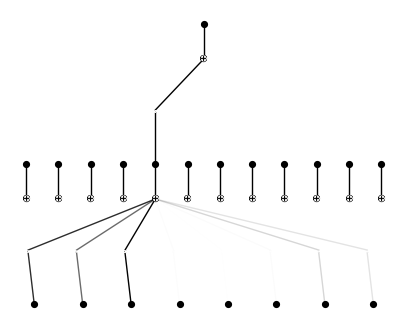

In [11]:
# KAN 학습
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
model.plot()

학습 가능 파라미터를 수정해보자 + model의 성질을 잠깐 출력해보자

=== Step 1: 스케일 파라미터 수정 실험 준비 ===
첫 번째 레이어 엣지 개수: torch.Size([8, 12])
원본 scale_base (처음 3개): tensor([-0.0297,  0.1495, -0.0708], grad_fn=<SliceBackward0>)
원본 scale_sp (처음 3개): tensor([0.2804, 0.3774, 0.3491], grad_fn=<SliceBackward0>)

--- 원본 모델 상태 ---
원본 공식: 0


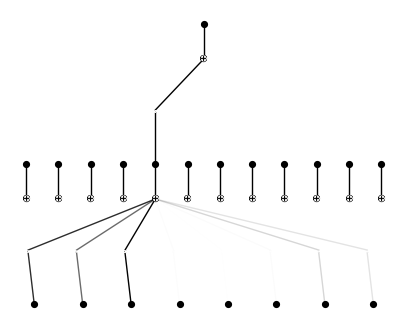

In [12]:
import torch
import numpy as np

# 원본 파라미터 백업
original_scale_base = model.act_fun[0].scale_base.clone()
original_scale_sp = model.act_fun[0].scale_sp.clone()

print("=== Step 1: 스케일 파라미터 수정 실험 준비 ===")
print(f"첫 번째 레이어 엣지 개수: {model.act_fun[0].scale_base.shape}")
print(f"원본 scale_base (처음 3개): {original_scale_base[0, :3]}")
print(f"원본 scale_sp (처음 3개): {original_scale_sp[0, :3]}")

print("\n--- 원본 모델 상태 ---")
model.plot()
try:
    formula_original = ex_round(model.symbolic_formula()[0][0], 4)
    print(f"원본 공식: {formula_original}")
except:
    print("심볼릭 공식 생성 실패 (아직 심볼화되지 않았을 수 있음)")

실험 1-1: Base function 비활성화 (w_b = 0)
수정된 scale_base (처음 3개): tensor([0., 0., 0.], requires_grad=True)
현재 scale_sp (처음 3개): tensor([0.2804, 0.3774, 0.3491], requires_grad=True)

--- Base function OFF 결과 ---
Base OFF 공식: 0

🔍 관찰 포인트:
- 활성화 함수가 더 복잡하고 비선형적으로 변했나요?
- 스플라인만 사용하므로 더 '구불구불한' 패턴을 보이나요?


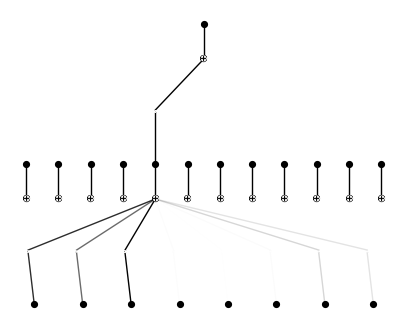

In [13]:
print("="*50)
print("실험 1-1: Base function 비활성화 (w_b = 0)")
print("="*50)

with torch.no_grad():
    model.act_fun[0].scale_base.fill_(0.0)  # 모든 base 함수 끄기
    print(f"수정된 scale_base (처음 3개): {model.act_fun[0].scale_base[0, :3]}")
    print(f"현재 scale_sp (처음 3개): {model.act_fun[0].scale_sp[0, :3]}")

print("\n--- Base function OFF 결과 ---")
model.plot()
try:
    formula_no_base = ex_round(model.symbolic_formula()[0][0], 4)
    print(f"Base OFF 공식: {formula_no_base}")
except:
    print("심볼릭 공식 생성 실패")

print("\n🔍 관찰 포인트:")
print("- 활성화 함수가 더 복잡하고 비선형적으로 변했나요?")
print("- 스플라인만 사용하므로 더 '구불구불한' 패턴을 보이나요?")


실험 1-2: Spline function 비활성화 (w_s = 0)
현재 scale_base (처음 3개): tensor([1., 1., 1.], requires_grad=True)
수정된 scale_sp (처음 3개): tensor([0., 0., 0.], requires_grad=True)

--- Spline function OFF 결과 ---
Spline OFF 공식: 0

🔍 관찰 포인트:
- 활성화 함수가 단순해졌나요? (보통 SiLU 함수만 남음)
- 모델이 더 선형적인 동작을 보이나요?
- 원본 대비 성능이나 복잡도가 어떻게 변했나요?


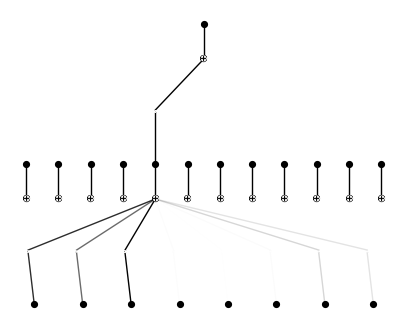

In [14]:
print("="*50)
print("실험 1-2: Spline function 비활성화 (w_s = 0)")
print("="*50)

with torch.no_grad():
    model.act_fun[0].scale_base.fill_(1.0)  # base w_b를 다 1로 만들기 -- 여기 origin scale_base 불러오는 것으로 수정하기
    model.act_fun[0].scale_sp.fill_(0.0)   # 모든 spline 함수 끄기
    print(f"현재 scale_base (처음 3개): {model.act_fun[0].scale_base[0, :3]}")
    print(f"수정된 scale_sp (처음 3개): {model.act_fun[0].scale_sp[0, :3]}")

print("\n--- Spline function OFF 결과 ---")
model.plot()
try:
    formula_no_spline = ex_round(model.symbolic_formula()[0][0], 4)
    print(f"Spline OFF 공식: {formula_no_spline}")
except:
    print("심볼릭 공식 생성 실패")

print("\n🔍 관찰 포인트:")
print("- 활성화 함수가 단순해졌나요? (보통 SiLU 함수만 남음)")
print("- 모델이 더 선형적인 동작을 보이나요?")
print("- 원본 대비 성능이나 복잡도가 어떻게 변했나요?")


실험 1-3: Base vs Spline 비율 조정
강화된 scale_base (처음 3개): tensor([-0.1487,  0.7477, -0.3540], requires_grad=True)
약화된 scale_sp (처음 3개): tensor([0.0561, 0.0755, 0.0698], requires_grad=True)

--- 비율 조정 결과 (Base 강화, Spline 약화) ---
비율 조정 공식: 0

🔍 관찰 포인트:
- Base가 강화되어 더 단순하고 매끄러운 패턴을 보이나요?
- Spline이 약화되어 비선형성이 줄어들었나요?
- 원본과 비교했을 때 어떤 부분이 변했나요?


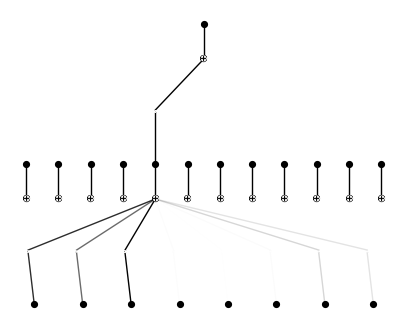

In [15]:
print("="*50)
print("실험 1-3: Base vs Spline 비율 조정")
print("="*50)

# 원본으로 일단 복원
with torch.no_grad():
    model.act_fun[0].scale_base.copy_(original_scale_base)
    model.act_fun[0].scale_sp.copy_(original_scale_sp)

# 비율 실험: base를 5배 강화, spline을 0.2배 약화
with torch.no_grad():
    model.act_fun[0].scale_base *= 5.0    # base 함수 5배 강화
    model.act_fun[0].scale_sp *= 0.2      # spline 함수 0.2배 약화
    
    print(f"강화된 scale_base (처음 3개): {model.act_fun[0].scale_base[0, :3]}")
    print(f"약화된 scale_sp (처음 3개): {model.act_fun[0].scale_sp[0, :3]}")

print("\n--- 비율 조정 결과 (Base 강화, Spline 약화) ---")
model.plot()
try:
    formula_ratio = ex_round(model.symbolic_formula()[0][0], 4)
    print(f"비율 조정 공식: {formula_ratio}")
except:
    print("심볼릭 공식 생성 실패")

print("\n🔍 관찰 포인트:")
print("- Base가 강화되어 더 단순하고 매끄러운 패턴을 보이나요?")
print("- Spline이 약화되어 비선형성이 줄어들었나요?")
print("- 원본과 비교했을 때 어떤 부분이 변했나요?")


실험 1-4: 특정 엣지만 선택적으로 수정
수정된 엣지 [0→4]:
  scale_base: 10.0
  scale_sp: 0.0

--- 특정 엣지 수정 결과 ---
특정 엣지 수정 공식: 0

🔍 관찰 포인트:
- 특정 입력 변수(첫 번째 입력)의 영향력이 변했나요?
- 다른 엣지들은 그대로인 상태에서 하나만 바뀐 효과를 관찰할 수 있나요?
- 전체 모델에서 이 하나의 엣지가 얼마나 중요한 역할을 하는지 알 수 있나요?


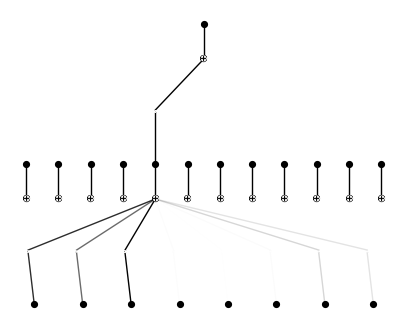

In [ ]:
print("="*50)
print("실험 1-4: 특정 엣지만 선택적으로 수정")
print("="*50)

# 원본으로 복원
with torch.no_grad():
    model.act_fun[0].scale_base.copy_(original_scale_base)
    model.act_fun[0].scale_sp.copy_(original_scale_sp)

# 첫 번째 입력(0)과 첫 번째 출력(0) 엣지만 극단적으로 수정
target_input, target_output = 0, 4

with torch.no_grad():
    model.act_fun[0].scale_base[target_input, target_output] *= 10.0  # 이 엣지만 base 10배
    model.act_fun[0].scale_sp[target_input, target_output] = 0.0     # 이 엣지만 spline 끄기
    
    print(f"수정된 엣지 [{target_input}→{target_output}]:")
    print(f"  scale_base: {model.act_fun[0].scale_base[target_input, target_output]}")
    print(f"  scale_sp: {model.act_fun[0].scale_sp[target_input, target_output]}")

print("\n--- 특정 엣지 수정 결과 ---")
model.plot()
try:
    formula_specific = ex_round(model.symbolic_formula()[0][0], 4)
    print(f"특정 엣지 수정 공식: {formula_specific}")
except:
    print("심볼릭 공식 생성 실패")

print("\n🔍 관찰 포인트:")
print("- 특정 입력 변수(첫 번째 입력)의 영향력이 변했나요?")
print("- 다른 엣지들은 그대로인 상태에서 하나만 바뀐 효과를 관찰할 수 있나요?")
print("- 전체 모델에서 이 하나의 엣지가 얼마나 중요한 역할을 하는지 알 수 있나요?")


실험 완료 - 원본 상태로 복원
✅ 원본 상태로 복원 완료!
복원된 scale_base (처음 3개): tensor([-0.0297,  0.1495, -0.0708], grad_fn=<SliceBackward0>)
복원된 scale_sp (처음 3개): tensor([0.2804, 0.3774, 0.3491], grad_fn=<SliceBackward0>)

--- 복원된 원본 모델 ---

📋 Step 1 실험 요약:
1. Base function OFF: 스플라인만 사용 → 더 복잡한 비선형 패턴
2. Spline function OFF: Base만 사용 → 더 단순한 선형적 패턴
3. 비율 조정: Base/Spline 비율 변경 → 복잡도 조절
4. 특정 엣지 수정: 개별 연결 조작 → 국소적 영향 관찰

다음 Step 2로 진행할 준비가 되었습니다! 🚀


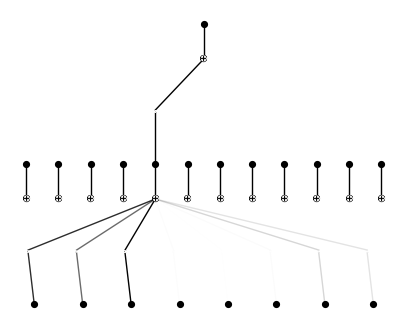

In [17]:
print("="*50)
print("실험 완료 - 원본 상태로 복원")
print("="*50)

with torch.no_grad():
    model.act_fun[0].scale_base.copy_(original_scale_base)
    model.act_fun[0].scale_sp.copy_(original_scale_sp)

print("✅ 원본 상태로 복원 완료!")
print(f"복원된 scale_base (처음 3개): {model.act_fun[0].scale_base[0, :3]}")
print(f"복원된 scale_sp (처음 3개): {model.act_fun[0].scale_sp[0, :3]}")

print("\n--- 복원된 원본 모델 ---")
model.plot()

print("\n📋 Step 1 실험 요약:")
print("1. Base function OFF: 스플라인만 사용 → 더 복잡한 비선형 패턴")
print("2. Spline function OFF: Base만 사용 → 더 단순한 선형적 패턴") 
print("3. 비율 조정: Base/Spline 비율 변경 → 복잡도 조절")
print("4. 특정 엣지 수정: 개별 연결 조작 → 국소적 영향 관찰")
print("\n다음 Step 2로 진행할 준비가 되었습니다! 🚀")


In [18]:
# 1. 모델의 전체 구조를 친절하게 출력해보기 (가장 추천!)
print("--- 모델의 전체 구조 (print) ---")
print(model)

# 2. 모델이 가진 모든 속성(변수, 함수) 리스트를 확인해보기
print("\n--- 모델의 모든 속성 리스트 (dir) ---")
print(dir(model))


--- 모델의 전체 구조 (print) ---
MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

--- 모델의 모든 속성 리스트 (dir) ---
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_

학습가능 파라미터 수 

In [19]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습가능 파라미터 수: {num_params:,}")

for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:40s} {p.shape} {p.numel():5d}")


학습가능 파라미터 수: 1,296
act_fun.0.coef                           torch.Size([8, 12, 6])   576
act_fun.0.scale_base                     torch.Size([8, 12])    96
act_fun.0.scale_sp                       torch.Size([8, 12])    96
act_fun.1.coef                           torch.Size([12, 1, 6])    72
act_fun.1.scale_base                     torch.Size([12, 1])    12
act_fun.1.scale_sp                       torch.Size([12, 1])    12
symbolic_fun.0.affine                    torch.Size([12, 8, 4])   384
symbolic_fun.1.affine                    torch.Size([1, 12, 4])    48


학습가능한 파라미터의 리스트를 나열해보자

In [20]:
import numpy as np
import torch

def print_parameters(model):
  
    
    target_layers = None
    model_type_name = type(model).__name__   # class 이름 알려주기  -- 보통 MultKIKAN이다
    
    print(f"(감지된 모델 타입: {model_type_name})")
    


   
    if model_type_name == 'MultKAN':
        target_layers = model.act_fun
    elif model_type_name == 'KAN':
        target_layers = model.layers
    else:
        print(f"[에러] 지원되지 않는 모델 타입입니다: {model_type_name}")
        return





    # layer 자체의 coef 속성에 직접 접근합니다.
    for i, layer in enumerate(target_layers):                        # enumerate 는 layer의 원소와 이름을 쌍으로 가져옴   # (0, 첫번째 레이어), (1, 두번째 레이어), ...

        print(f"\n  [ Layer {i} ({type(layer).__name__}) ] ")
        
        # 'KANLayer' 객체(layer)가 가진 .coef 속성을 직접 가져옵니다.
        # 이로써 내부 for문이 완전히 사라지고 코드가 더 간결해졌습니다.
        coeffs = layer.coef.detach().cpu().numpy()
        
        print(f" \n > Coefficients Shape: {coeffs.shape}")
        print(f"  > Coefficients List (전체 파라미터)")
        print(f"{coeffs}")  # 이게 파라미터들의 리스트
            
    

# 이 최종 완성된 함수를 실행합니다.
print_parameters(model)

# [팁] 파라미터 리스트가 너무 길어서 [...]로 생략된다면,NumPy의 출력 옵션을 설정하여 전체 배열을 볼 수 있음
# np.set_printoptions(threshold=np.inf)




(감지된 모델 타입: MultKAN)

  [ Layer 0 (KANLayer) ] 
 
 > Coefficients Shape: (8, 12, 6)
  > Coefficients List (전체 파라미터)
[[[ 1.73718501e-02 -3.43479253e-02 -6.64361985e-04  1.11090774e-02
    4.30452898e-02  4.67861481e-02]
  [ 5.86232059e-02  2.04189867e-01  9.67531949e-02  4.57777567e-02
   -7.90514275e-02 -5.97767718e-02]
  [-6.27715737e-02 -8.60250667e-02 -4.24970500e-02 -9.13366303e-03
    4.67293039e-02  5.97330779e-02]
  [-7.55276084e-02 -6.23924695e-02 -4.56266291e-02 -2.57830303e-02
   -1.57734507e-03  2.01082360e-02]
  [-2.43144795e-01  2.39047304e-01  1.47484347e-01  6.44966066e-02
   -7.60879368e-02 -1.38885126e-01]
  [ 4.13936153e-02  3.07239685e-02  1.64053179e-02 -9.60812555e-04
   -2.07921565e-02 -4.47404124e-02]
  [ 3.04266587e-02  3.36498544e-02  3.32632624e-02  2.94334553e-02
    2.79580951e-02  3.09191197e-02]
  [-6.27955049e-02 -5.15330434e-02 -3.75561751e-02 -2.08712574e-02
   -8.91445845e-04  1.86889246e-02]
  [-4.79749516e-02 -5.61918877e-02 -6.04826137e-02 -6.706767

saving model version 0.2


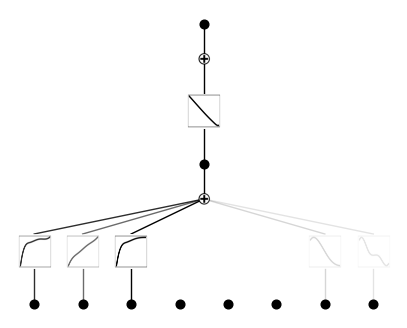

In [21]:
#pruning
model = model.prune(node_th=1e-2, edge_th=3e-2)  # 더 자르고 싶으면 값을 높이고, 덜 자르고 변수를 많이 있게 하고 싶으면 값을 낮추기
model.plot()

| train_loss: 1.65e-02 | test_loss: 1.54e-02 | reg: 3.71e+00 | : 100%|█| 50/50 [00:08<00:00,  5.63it


saving model version 0.3


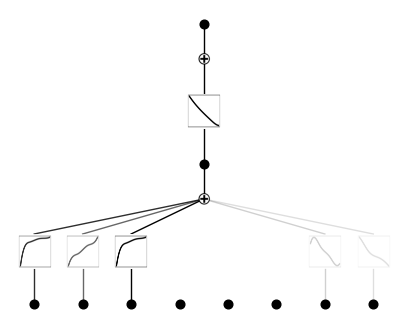

In [22]:
#학습
model.fit(dataset, opt="LBFGS", steps=50)  # update_grid 가 False일때랑 True일때의 차이는?
model.plot()

step10. KAN refine(grid extension) 후 재학습

saving model version 0.4


| train_loss: 1.25e-02 | test_loss: 1.62e-02 | reg: 3.75e+00 | : 100%|█| 50/50 [00:12<00:00,  3.99it


saving model version 0.5


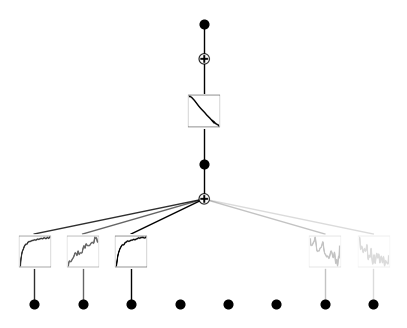

In [23]:
# refine(grid extension) 그리드 세분화(구간 세분화)(전체 구간 개수 30개로 변화) 
model = model.refine(30)
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

step11. KAN symbolification

fixing (0,0,0) with exp, r2=0.9814107418060303, c=2
fixing (0,1,0) with x, r2=0.9497223496437073, c=1
fixing (0,2,0) with x, r2=0.728888213634491, c=1
fixing (0,3,0) with 0
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=0.7060781717300415, c=1
fixing (0,7,0) with x, r2=0.6618900895118713, c=1
fixing (1,0,0) with x, r2=0.9917652010917664, c=1
saving model version 0.6


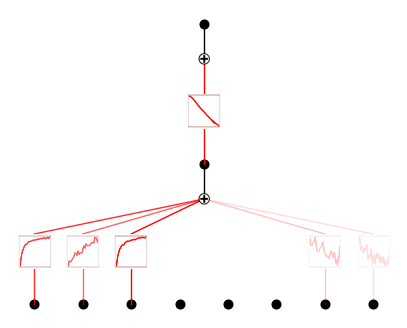

In [24]:
# 자동 모드로 심볼릭 회귀 수행
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin']   #'x^(-1)', 'x^(-2)', 'x^(-3)', 'x^(-4)'
model.auto_symbolic(lib=lib)
model.plot()

| train_loss: 7.00e-02 | test_loss: 7.26e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:03<00:00, 12.68it


saving model version 0.7


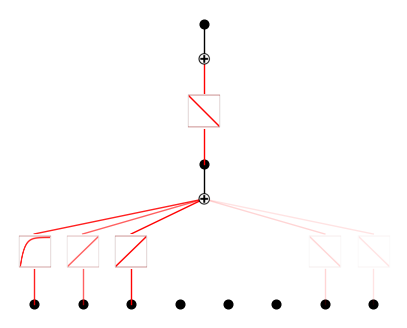

In [25]:
# symbolic 함수로 대체 후 학습
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

step12. symbolic 수식 출력

In [26]:
# 심볼릭 수식 출력
formula = ex_round(model.symbolic_formula()[0][0], 4)  # ex_round(  , 4) -- 소수점 뒤에 숫자 4개? // 
print("formula =" , formula)  
print('(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)')


formula = -0.1248*x_2 - 0.4409*x_3 + 0.028*x_7 + 0.0185*x_8 + 0.4909 + 0.5633*exp(-8.7999*x_1)
(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)


step13. KAN이 예측한 수식 정확도 검증을 위한 함수 정의

In [27]:
# validation set으로 성능을 평가하는 함수 만들기
def evaluate_model_performance(model, dataset, scaler_y, phase="validation"):    # phase = validation 아니면 test 이다
    
    
    if phase == "validation":
        input_tensor = dataset['val_input']
        label_tensor = dataset['val_label']
    elif phase == "test":
        input_tensor = dataset['test_input']
        label_tensor = dataset['test_label']
    else:
        raise ValueError("phase는 'validation' 또는 'test'만 가능합니다")
    
    # 예측 수행
    with torch.no_grad():  # 굳이 기울기 계산할 필요 X because 이거는 test 이기에 학습 X --- 시간 더 빠르게 하려고 torch.no_grad()
        pred_norm = model(input_tensor) #input_tensor 는 val_inut or test_input / pred_norm은 그에 대한 출력값
    
    # 역정규화
    pred_real = scaler_y.inverse_transform(pred_norm.cpu().detach().numpy())   # pred_real 은 0.1~0.9 사이의 입력 val_input or test_input을 받고 출력된 값은 다시 역정규화 한 실제 출력값
    label_real = scaler_y.inverse_transform(label_tensor.cpu().detach().numpy()) # label_real은 0.1~0.9 사이의 입력 val_label or test_label을 받고 출력한 값 역정규화
    # inverse_transform 함수는  numpy 를 입력으로 받기 떄문에 pytorch tensor를 cpu로 옮기고 numpy로 변환
    
    # numpy는 cpu에서만 돌아가니까 tensor를 .cpu로 옮기고 그다음 tensor의 추가정보 (numpy 정보 + 어떻게 계산되었는지 식에 대한 정보)를 detach --- 그 다음에 .numpy()를 통해 numpy로 변환
    
    # 성능 지표 계산 from 역정규화된 label_real, pred_real 값들 from val input or test input + numpy에서 계산
    rmse = np.sqrt(mean_squared_error(label_real, pred_real))  # 오차 제곱 평균의 루트
    r2 = r2_score(label_real, pred_real)  #1에 가까울수록 좋다 
    mae = np.mean(np.abs(label_real - pred_real)) # 오차 절댓값들의 평균 -- MAE
    
    print(f"{phase} SET Performance Evaluation") # phase = validation 또는 test 
    print(f"RMSE: {rmse:.4f}")     # f"{변수:포맷코드}"
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    print(f"실제값 평균: {label_real.mean():.4f}")  #label_real의 평균값(실제값)
    print(f"예측값 평균: {pred_real.mean():.4f}")   #pred_real의 평균값(KAN 모델로 예측한 값)
    
    return pred_real, label_real, {'rmse': rmse, 'r2': r2, 'mae': mae}

Step14. Validation data(검증셋)으로 성능 평가

In [28]:
# validation dataset(검증셋)으로 성능 평가 (모델 개발 과정에서)
val_pred, val_actual, val_metrics = evaluate_model_performance(model, dataset, scaler_y, "validation")

#scaler_y : step5 에서 정의한 정규화된 y 변환법
# validation --- 검증셋 이용할거라는 의미 / 나중에 
# val_pred 변수: evaluate_model_performance 함수가 반환한 첫 번째 결과물(pred_real)(모델의 예측값 배열)이 저장
# val_actual 변수: 함수가 반환한 두 번째 결과물(label_real)(실제 정답 값 배열)이 저장
# val_metrics 변수: 함수가 반환한 세 번째 결과물(RMSE, R², MAE가 담긴 딕셔너리)이 저장


validation SET Performance Evaluation
RMSE: 0.1327
R²: 0.7479
MAE: 0.0879
실제값 평균: 0.4463
예측값 평균: 0.4332


step15. KAN이 예측한 수식의 정확도 최종계산 _ using test_input, test_label

In [29]:
# 모든 모델 개발이 완료된 후 최종 한 번만 수행
print("최종 테스트셋 평가")


# 최종 테스트셋 평가(phase만 'test'로 변경하여 테스트 데이터를 사용)(이전에 정의한 evaluate_model_performance 함수를 그대로 사용)
test_pred, test_actual, test_metrics = evaluate_model_performance(
    model, dataset, scaler_y, "test"
)

# test_pred : 모델의 예측값 , test_actual : 실제 정답 값 배열 , test_metrics : (RMSE, R², MAE가 담긴 딕셔너리)

print(f"\nFinal model performance evaluation:")
print(f"Test set RMSE: {test_metrics['rmse']:.4f}")
print(f"Test set R²: {test_metrics['r2']:.4f}")
print(f"Test set MAE: {test_metrics['mae']:.4f}")


최종 테스트셋 평가
test SET Performance Evaluation
RMSE: 0.1265
R²: 0.7407
MAE: 0.0880
실제값 평균: 0.4667
예측값 평균: 0.4620

Final model performance evaluation:
Test set RMSE: 0.1265
Test set R²: 0.7407
Test set MAE: 0.0880


step16. KAN 예측값 / 실제값 그래프

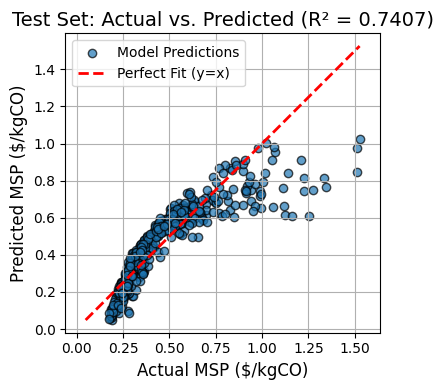

In [30]:
# step14. KAN 예측값 / 실제값 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))  # 도화지 그리기~

# test_actual (x축) vs test_pred (y축) , alpha = 투명도
plt.scatter(test_actual, test_pred, alpha=0.7, edgecolors='k', label='Model Predictions')

# 제일 작은 값, 제일 큰 값 설정
min_val = min(test_actual.min(), test_pred.min())
max_val = max(test_actual.max(), test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (y=x)')  # y = x 선긋기

# 그래프 제목과 축 레이블 설정
plt.xlabel("Actual " + predicting , fontsize=12)   # Actual 다음에 우리가 보고자 하는 output predicting 변수가 뜸
plt.ylabel("Predicted " + predicting, fontsize=12) # 
plt.title(f'Test Set: Actual vs. Predicted (R² = {test_metrics["r2"]:.4f})', fontsize=14)
plt.legend()
plt.grid(True)  # 격자 on 
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.tight_layout()
plt.show()


잔차 플롯 (Residual Plot): 모델의 예측 오차 패턴 분석

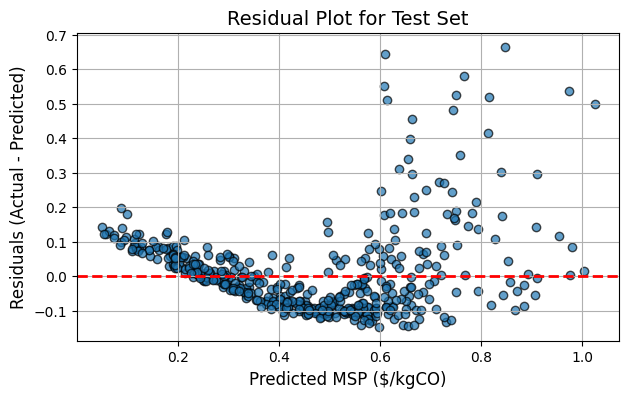

In [31]:
# 1. 잔차 계산 (실제값 - 예측값)
residuals = test_actual - test_pred

# 2. 잔차 플롯 시각화
plt.figure(figsize=(7, 4))

# x축은 예측값, y축은 잔차
plt.scatter(test_pred, residuals, alpha=0.7, edgecolors='k')

# y=0 기준선 추가 (오차가 0인 선)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel("Predicted "+predicting, fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot for Test Set', fontsize=14)
plt.grid(True)
plt.show()


2. 개별 변수 영향도 플롯 (Partial Dependence Plot): 변수-결과 관계 시각화

--- 모든 입력 변수에 대한 개별 영향도 플롯 ---


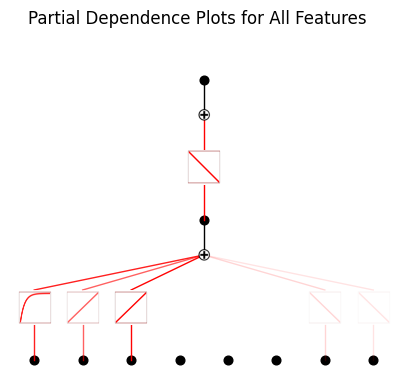

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 1. (NameError 해결) feature_names 리스트를 먼저 정의합니다.
feature_names = [
    "Current density", "Faradaic efficiency", "CO coversion", "Voltage",
    "Electricity cost", "Membrain cost", "Capture energy", "Crossover rate"
]

try:
    print("--- 모든 입력 변수에 대한 개별 영향도 플롯 ---")
    
    # 2. (TypeError 해결) 'vars' 인자 없이 plot() 함수를 호출합니다.
    # 이렇게 하면 8개 변수 각각에 대한 영향도 그래프가 한 번에 그려집니다.
    model.plot()
    
    # 전체 그래프에 대한 제목 설정 (선택 사항)
    plt.suptitle('Partial Dependence Plots for All Features', y=1.02)
    plt.show()

except Exception as e:
    print(f"오류가 발생했습니다: {e}")
    print("이전 단계에서 'model' 객체가 성공적으로 생성되었는지 확인해주세요.")



In [33]:
# step11의 코드를 다시 실행
formula = ex_round(model.symbolic_formula()[0][0], 4)
print("formula=", formula)

# 여기서 맨 왼쪽부터  x_1부터 x_8 


formula= -0.1248*x_2 - 0.4409*x_3 + 0.028*x_7 + 0.0185*x_8 + 0.4909 + 0.5633*exp(-8.7999*x_1)


-------

------

------------------------------------------------------------------------------------------------------------------------------------------------

step17.실제 KAN이 구현한 수식에 X값을 대입해서 결과 구해보기_역정규화 이용

In [34]:
# 이전에 학습에 사용했던 scaler_X 와 scaler_y 객체가 필요합니다.

# 1. 입력 변수(X)의 최소/최대값 추출
#    사용된 변수의 순서에 맞게 이름을 지정합니다.
feature_names = [
    "Current density (mA/cm2)", "Faradaic efficiency (%)", "CO coversion",
    "Voltage (V)", "Electricity cost ($/kWh)", "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", "Crossover rate"
]

print("--- [입력 변수(X) 정규화 키] ---")
for i, name in enumerate(feature_names):
    min_val = scaler_X.data_min_[i]
    max_val = scaler_X.data_max_[i]
    print(f"x_{i+1} ({name}):")
    print(f"  min = {min_val:.8f}")
    print(f"  max = {max_val:.8f}\n")

# 2. 출력 변수(y)의 최소/최대값 추출
y_min = scaler_y.data_min_[0]
y_max = scaler_y.data_max_[0]

print("--- [출력 변수(y) 역정규화 키] ---")
print(f"y_min = {y_min:.8f}")
print(f"y_max = {y_max:.8f}")


--- [입력 변수(X) 정규화 키] ---
x_1 (Current density (mA/cm2)):
  min = 123.17073171
  max = 1999.62015194

x_2 (Faradaic efficiency (%)):
  min = 0.50009796
  max = 0.98970612

x_3 (CO coversion):
  min = 0.02733906
  max = 0.59988205

x_4 (Voltage (V)):
  min = 1.30043982
  max = 3.49868053

x_5 (Electricity cost ($/kWh)):
  min = 0.05002999
  max = 0.09999000

x_6 (Membrain cost ($/m2)):
  min = 285.03798481
  max = 348.32067173

x_7 (Catpure energy (GJ/ton)):
  min = 3.00039984
  max = 4.99640144

x_8 (Crossover rate):
  min = 0.00039984
  max = 1.99880048

--- [출력 변수(y) 역정규화 키] ---
y_min = 0.17031000
y_max = 1.56500635


In [35]:
# step11의 코드를 다시 실행
formula = ex_round(model.symbolic_formula()[0][0], 4)
print("formula=", formula)
print('(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)')


formula= -0.1248*x_2 - 0.4409*x_3 + 0.028*x_7 + 0.0185*x_8 + 0.4909 + 0.5633*exp(-8.7999*x_1)
(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)


python에서도 시험삼아 몇 개 출력해보기

In [36]:
import numpy as np
import pandas as pd
from sympy import sympify, symbols, lambdify 
# sympy 라이브러리 추가

# 1. KAN 모델에서 직접 심볼릭 수식 문자열을 가져오기
formula_str = model.symbolic_formula()[0][0] # 실제 모델에서 가져오는 코드

print(f"▶ 자동으로 감지된 수식: y = {formula_str}\n")

# 2. 모든 변수(x_1 ~ x_8)를 기호로 정의
num_features = len(feature_names)
x_vars = symbols(f'x_1:{num_features + 1}')

# 3. 문자열 수식을 실제 계산 가능한 함수로 변환합니다. (핵심 부분)
#    lambdify는 sympy 수식을 매우 빠른 numpy 함수로 바꿔주는 기능입니다.
symbolic_func = lambdify(x_vars, sympify(formula_str), 'numpy')

# 4. 새로운 '만능' 예측 함수를 정의합니다.
def auto_symbolic_prediction(x_norm):
    """
    정규화된 입력 데이터(x_norm)를 받아,
    자동으로 생성된 symbolic_func를 사용해 예측값을 반환합니다.
    """
    # x_norm 배열의 각 열을 개별 인자로 분리하여 함수에 전달합니다.
    # 예: symbolic_func(x_norm[:,0], x_norm[:,1], ..., x_norm[:,7])
    # x_norm.T는 배열을 전치하여 각 행이 변수가 되도록 합니다.
    return symbolic_func(*x_norm.T)

# --- [자동화된 수식 처리 부분 끝] ---


# 2. 역정규화에 사용되는 수식 출력 (이전과 동일)
min_val = scaler_y.min_[0]
scale_range = 1 / scaler_y.scale_[0]
print("==============================================================")
print("### 역정규화 (Inverse Normalization)에 사용되는 수식 ###")
print(f"실제값 = (정규화된 값 * (최대값 - 최소값)) + 최소값")
print(f"실제값 = (정규화된 값 * {scale_range:.4f}) + {min_val:.4f}")
print("==============================================================\n")


# 4. 테스트 데이터셋 전체를 사용하여 예측을 수행합니다.
test_input_norm = dataset['test_input']
# 여기서 새롭게 정의한 자동화 함수를 호출합니다!
y_pred_norm = auto_symbolic_prediction(test_input_norm)


# 5. 이후 모든 코드는 이전과 완전히 동일합니다.
y_pred_norm_reshaped = y_pred_norm.reshape(-1, 1)
y_pred_real_scale = scaler_y.inverse_transform(y_pred_norm_reshaped)
y_true_real_scale = scaler_y.inverse_transform(dataset['test_label'])
results_df = pd.DataFrame({
    '실제값 ': y_true_real_scale.flatten(),
    '수식 예측값 ': y_pred_real_scale.flatten()
})
pd.options.display.float_format = '{:.2f}'.format

print("--------- [단순화된 수식 모델]의 예측 성능 ---------")
print(results_df.head(30))


▶ 자동으로 감지된 수식: y = -0.124788018570728*x_2 - 0.440946501806949*x_3 + 0.028047372947083*x_7 + 0.0185323641757201*x_8 + 0.490861401333214 + 0.563346709021052*exp(-8.79992008209229*x_1)

### 역정규화 (Inverse Normalization)에 사용되는 수식 ###
실제값 = (정규화된 값 * (최대값 - 최소값)) + 최소값
실제값 = (정규화된 값 * 1.7434) + 0.0023

--------- [단순화된 수식 모델]의 예측 성능 ---------
    실제값   수식 예측값 
0   0.38     0.45
1   0.43     0.51
2   0.53     0.56
3   0.19     0.05
4   0.60     0.66
5   0.45     0.58
6   0.20     0.11
7   0.37     0.47
8   0.46     0.58
9   0.32     0.40
10  0.83     0.87
11  0.27     0.30
12  0.35     0.40
13  0.38     0.48
14  0.30     0.32
15  0.21     0.13
16  0.31     0.38
17  0.18     0.11
18  0.37     0.46
19  0.37     0.46
20  0.90     0.85
21  0.30     0.18
22  0.57     0.57
23  0.42     0.50
24  0.29     0.27
25  0.27     0.29
26  0.26     0.18
27  0.33     0.31
28  0.37     0.48
29  0.82     0.69
